In [1]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [2]:
# Load your cleaned CSV
df = pd.read_csv("vcf_feature_vectors.csv")

# Separate features and target
non_features = ["CHROM", "POS", "REF", "ALT", "GOLDEN"]
features = df.drop(columns=non_features)
target = df["GOLDEN"]

# Mutual Information

In [3]:
mi_scores = mutual_info_classif(features, target, discrete_features=False, random_state=42)

# Build a DataFrame for easy viewing
mi_df = pd.DataFrame({
    "Feature": features.columns,
    "MI_Score": mi_scores
}).sort_values(by="MI_Score", ascending=False)

# Display
print("\nTop Features by Mutual Information with GOLDEN:")
print(mi_df)


Top Features by Mutual Information with GOLDEN:
     Feature  MI_Score
12  F2R1_alt  0.181626
10  F1R2_alt  0.180511
7     AD_alt  0.176247
8         AF  0.158039
3    MBQ_alt  0.082295
5    MMQ_alt  0.053297
6     AD_ref  0.041173
9   F1R2_ref  0.034041
11  F2R1_ref  0.033099
1      GERMQ  0.030447
0         DP  0.028299
4    MMQ_ref  0.024724
2    MBQ_ref  0.011896


### MI Score Range | Interpretation
- 0.00 - 0.02 --> Very weak / noise
- 0.02 - 0.08 --> Weak signal, might still matter
- 0.08 - 0.15 --> Moderate predictive power
- 0.15 - 0.25 --> Strong feature, meaningful predictor
- \> 0.25     --> Very strong, dominant feature (rare in real biological VCFs)

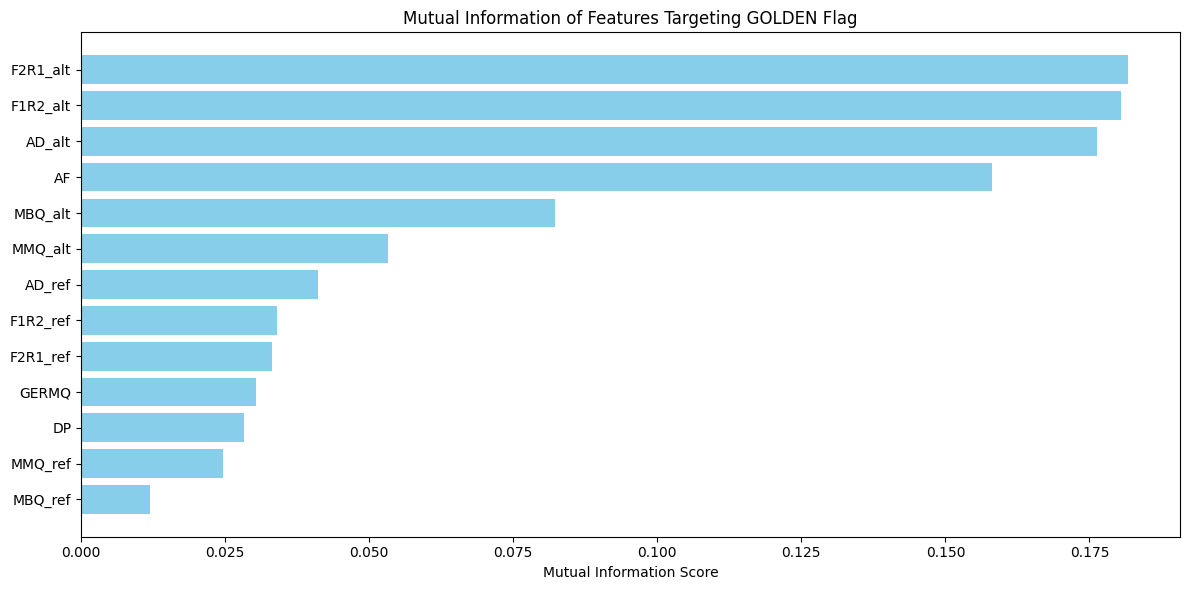

In [4]:
plt.figure(figsize=(12, 6))
plt.barh(mi_df["Feature"], mi_df["MI_Score"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Mutual Information of Features Targeting GOLDEN Flag")
plt.xlabel("Mutual Information Score")
plt.tight_layout()
plt.show()

# PCA

## PCA vs Mutual Information (MI) Feature Selection

| Aspect | Mutual Information (MI) | Principal Component Analysis (PCA) |
|:---|:---|:---|
| **Purpose** | Identify the most predictive features for a target variable (e.g., GOLDEN) | Find directions of maximum variance in data without considering any target |
| **Supervised?** | Yes (target-aware) | No (unsupervised) |
| **Feature Output** | Original features are kept | New synthetic features (principal components) are created |
| **Interpretability** | High (easy to explain selected features) | Low (principal components are combinations of many features) |
| **Goal** | Feature selection for predictive modeling | Dimensionality reduction for visualization or compression |
| **Best For** | Building interpretable ML models | Visualizing structure and clusters in the data |
| **When to Use** | When you want to improve predictive accuracy and model simplicity | When you want to explore data structure or reduce feature space |

---

- **Mutual Information (MI)** helps you **choose the best original features** for predictive modeling because it is **supervised**.
- **Principal Component Analysis (PCA)** helps you **visualize and compress data** but **loses direct feature meaning** because it is **unsupervised**.
- **PCA is not redundant after MI** — it complements it by revealing underlying structure and separability.

---


In [15]:
# Select Top 10 Features
top_features = mi_df["Feature"].head(9).tolist()
print("Top 7 Features Selected:")
print(top_features)

# Prepare data for PCA
X_selected = df[top_features]

Top 7 Features Selected:
['F2R1_alt', 'F1R2_alt', 'AD_alt', 'AF', 'MBQ_alt', 'MMQ_alt', 'AD_ref', 'F1R2_ref', 'F2R1_ref']


Number of PCA components to explain ≥95% variance: 4


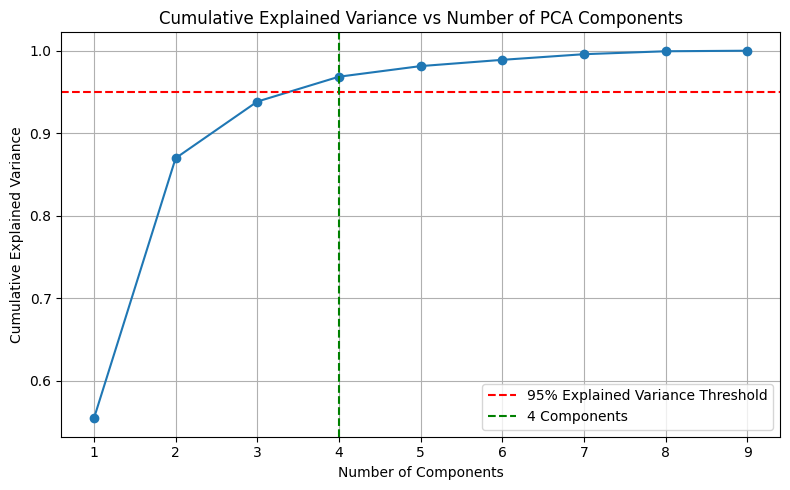

In [16]:
# 1. Fit full PCA (no limit on number of components)
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_selected)

# 2. Compute cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# 3. Find number of components needed to reach 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of PCA components to explain ≥95% variance: {n_components_95}")

# 4. Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance Threshold")
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f"{n_components_95} Components")
plt.title("Cumulative Explained Variance vs Number of PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LightGBM

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score,
                             brier_score_loss, precision_recall_curve)
import lightgbm as lgb
from sklearn.metrics import roc_curve

In [18]:
# Final PCA
pca_final = PCA(n_components=n_components_95)
X_pca_reduced = pca_final.fit_transform(X_selected)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
metrics_list = []
best_thresholds = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_pca_reduced, target)):
    
    X_train, X_test = X_pca_reduced[train_idx], X_pca_reduced[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    # Train LightGBM
    model = lgb.LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Threshold tuning: find best threshold to maximize F1-score
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_thresholds.append(best_thresh)
    
    # Apply optimal threshold
    y_pred = (y_proba >= best_thresh).astype(int)
    
    # Metrics
    metrics = {
        "Fold": fold+1,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Average Precision (PR AUC)": average_precision_score(y_test, y_proba),
        "Brier Score": brier_score_loss(y_test, y_proba),
        "Best Threshold": best_thresh
    }
    metrics_list.append(metrics)

[LightGBM] [Info] Number of positive: 9021, number of negative: 101005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 110026, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081990 -> initscore=-2.415615
[LightGBM] [Info] Start training from score -2.415615
[LightGBM] [Info] Number of positive: 9021, number of negative: 101005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 110026, number of used features: 4
[LightGBM] [Info] 

In [20]:
# Compile results
metrics_df = pd.DataFrame(metrics_list)
print("\n Cross-Validation Hotspot Matrix:")
print(metrics_df)

print("\n Mean Metrics Across Folds:")
print(metrics_df.mean(numeric_only=True))


 Cross-Validation Hotspot Matrix:
   Fold  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0     1  0.973207   0.814677  0.871397  0.842083  0.990375   
1     2  0.975752   0.856054  0.846563  0.851282  0.990519   
2     3  0.975025   0.851321  0.842642  0.846959  0.990465   
3     4  0.975387   0.827658  0.883814  0.854814  0.991213   
4     5  0.973569   0.822091  0.864745  0.842879  0.989749   

   Average Precision (PR AUC)  Brier Score  Best Threshold  
0                    0.901815     0.019512        0.347961  
1                    0.907437     0.018589        0.480768  
2                    0.904399     0.018973        0.441964  
3                    0.912352     0.018100        0.342765  
4                    0.906546     0.019440        0.361942  

 Mean Metrics Across Folds:
Fold                          3.000000
Accuracy                      0.974588
Precision                     0.834360
Recall                        0.861832
F1 Score                      0.847603
RO

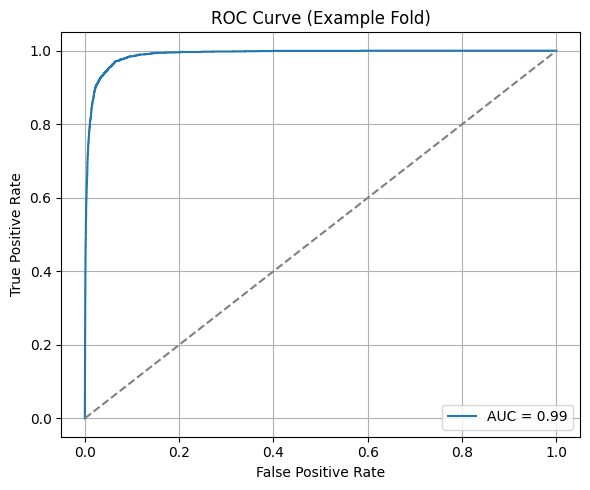

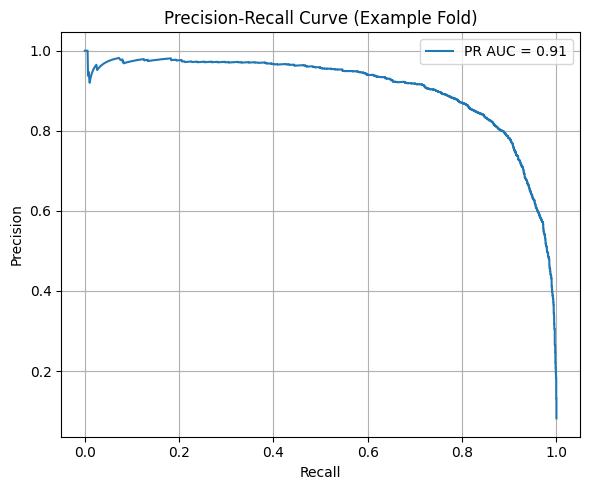

In [21]:
# Plot ROC Curve Example (last fold)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Example Fold)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve Example (last fold)
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, label=f"PR AUC = {average_precision_score(y_test, y_proba):.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Example Fold)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()